In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
os.chdir('/content/drive/MyDrive/final_year_project_dataset')

In [9]:
disease_types=['COVID', 'non-COVID']
data_dir = ''
train_dir = os.path.join(data_dir)

In [10]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (695).png,0,COVID
1,COVID/Covid (717).png,0,COVID
2,COVID/Covid (739).png,0,COVID
3,COVID/Covid (760).png,0,COVID
4,COVID/Covid (705).png,0,COVID


In [11]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (1152).png,0,COVID
1,COVID/Covid (516).png,0,COVID
2,COVID/Covid (95).png,0,COVID
3,COVID/Covid (860).png,0,COVID
4,COVID/Covid (692).png,0,COVID


In [12]:
#import pandas_profiling as pp
#pp.ProfileReport(train)

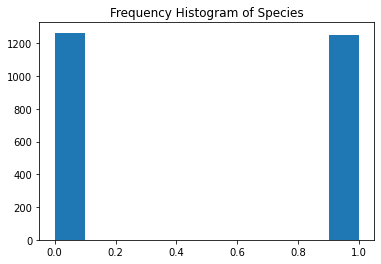

<Figure size 864x864 with 0 Axes>

In [13]:
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

In [14]:
IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [15]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

2513it [04:14,  9.86it/s]


Train Shape: (2513, 64, 64, 3)


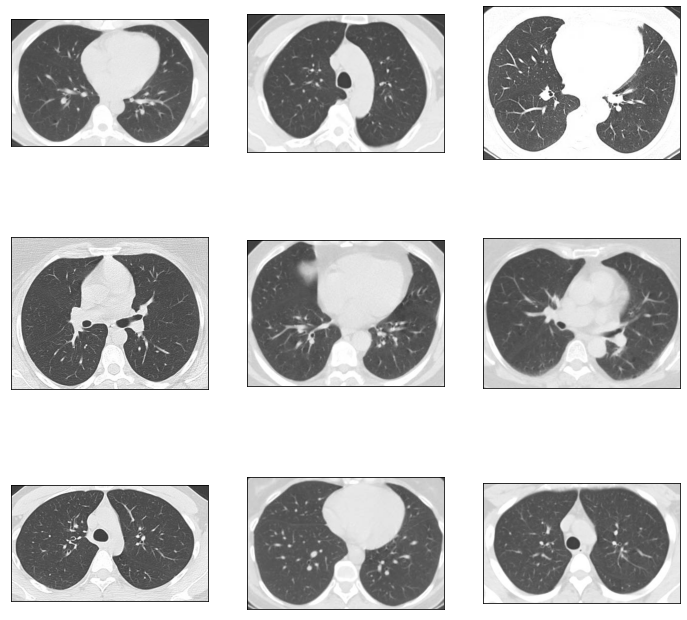

In [16]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            
            n += 1
# Displays first n images of class from training set
plot_defects('non-COVID', 3, 3)

In [17]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)
print(Y_train.shape)

(2513, 2)


In [18]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)


In [19]:
print(f'X_train:',X_train.shape)
print(f'X_val:',X_val.shape)
print(f'Y_train:',Y_train.shape)
print(f'Y_val:',Y_val.shape)

X_train: (2010, 64, 64, 3)
X_val: (503, 64, 64, 3)
Y_train: (2010, 2)
Y_val: (503, 2)


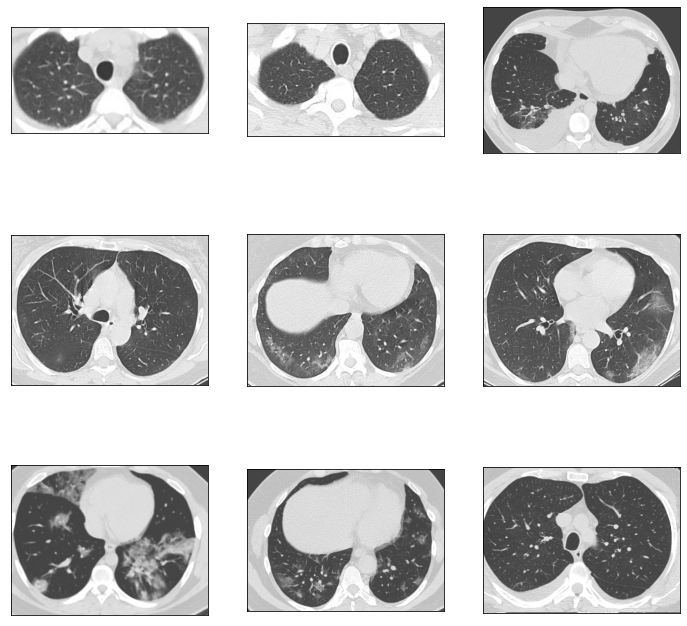

In [20]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('COVID', 3, 3)

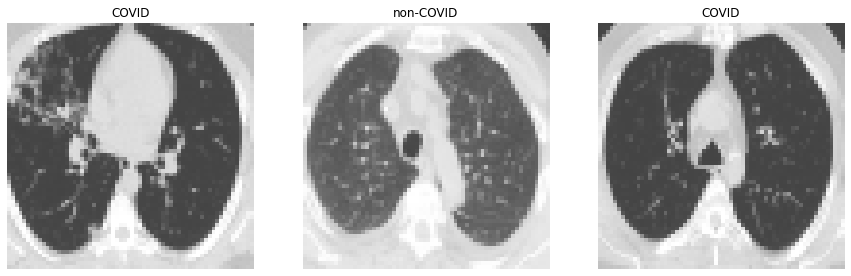

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [22]:
EPOCHS = 50
SIZE=64
N_ch=3

In [23]:
def build_resnet50():
    resnet50 = ResNet50(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = resnet50(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [24]:
model = build_resnet50()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 3)         84        
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


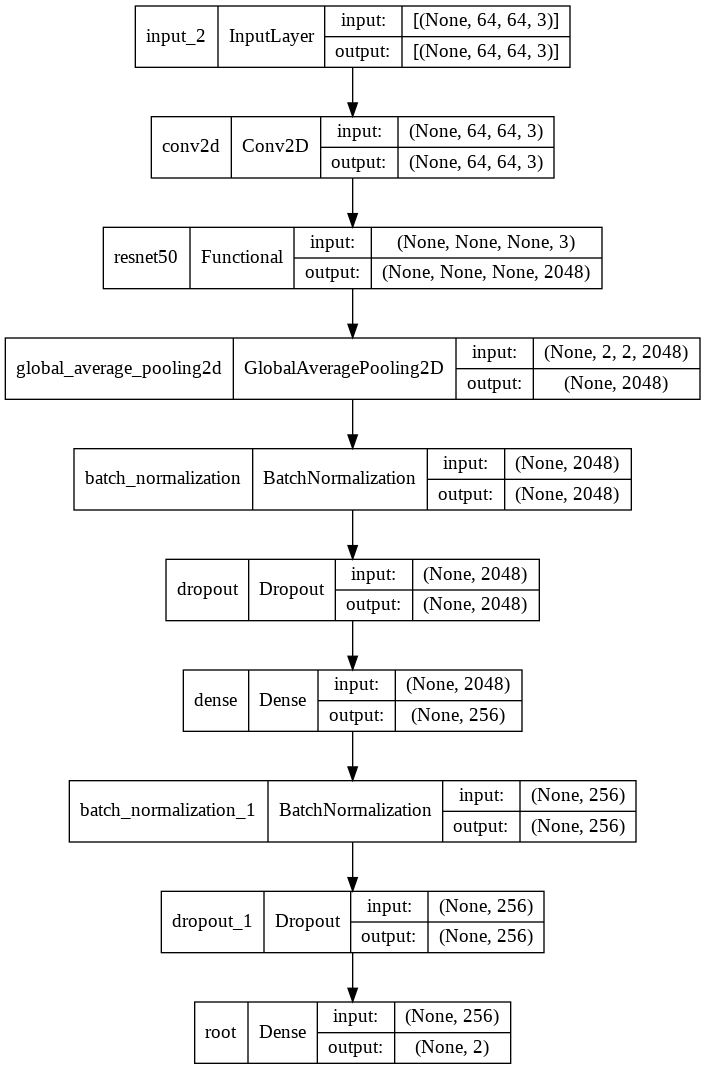

In [25]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [26]:
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 1.1733 - accuracy: 0.5313 
Epoch 00001: val_loss improved from inf to 0.99531, saving model to model.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


31/31 [==============================] - 342s 11s/step - loss: 1.1733 - accuracy: 0.5313 - val_loss: 0.9953 - val_accuracy: 0.4970 - lr: 0.0030
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.9912 - accuracy: 0.5987 
Epoch 00002: val_loss improved from 0.99531 to 0.78506, saving model to model.h5
31/31 [==============================] - 342s 11s/step - loss: 0.9912 - accuracy: 0.5987 - val_loss: 0.7851 - val_accuracy: 0.4970 - lr: 0.0030
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.9410 - accuracy: 0.6274 
Epoch 00003: val_loss did not improve from 0.78506
31/31 [==============================] - 333s 11s/step - loss: 0.9410 - accuracy: 0.6274 - val_loss: 0.7908 - val_accuracy: 0.4970 - lr: 0.0030
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.8399 - accuracy: 0.6413
Epoch 00004: val_loss did not improve from 0.78506
31/31 [==============================] - 302s 10s/step - loss: 0.8399 - accuracy: 0.6413 - val_loss: 

In [27]:
from sklearn.metrics import confusion_matrix
#model = load_model('../output/kaggle/working/model.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

16/16 [==============================] - 6s 386ms/step - loss: 0.2934 - accuracy: 0.8946
Final Loss: 0.29338300228118896, Final Accuracy: 0.8946322202682495


Text(0.5, 145.31999999999996, 'Predicted')

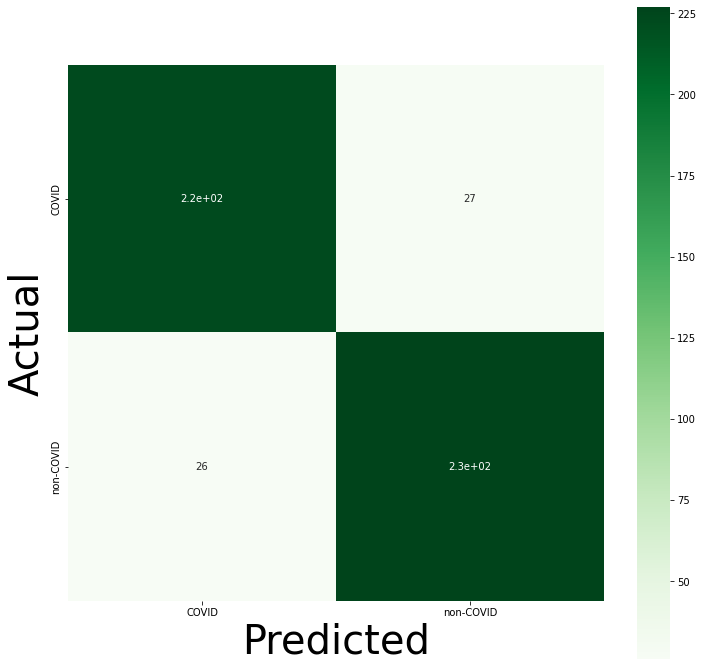

In [28]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

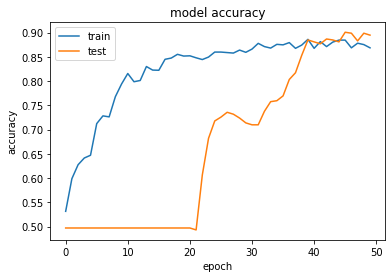

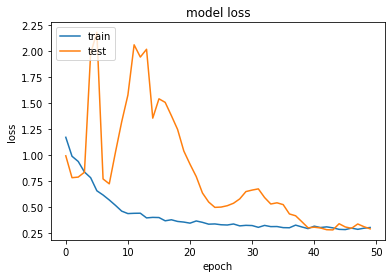

In [31]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


[0.97161174 0.02838831]


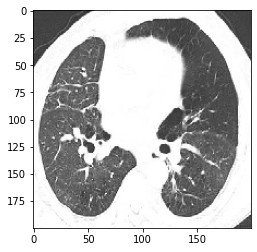

Prediction: Covid-19


In [46]:
from skimage import io
from keras.preprocessing import image
img = image.load_img('/content/drive/My Drive/final_year_project_dataset/COVID/Covid (1248).png', grayscale=False, target_size=(64, 64))
show_img=image.load_img('/content/drive/My Drive/final_year_project_dataset/COVID/Covid (1248).png', grayscale=False, target_size=(200, 200))
disease_class=['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])

[0.03953076 0.96046925]


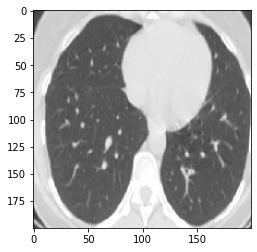

Prediction: Non Covid-19


In [52]:
from skimage import io
from keras.preprocessing import image
img = image.load_img('/content/drive/My Drive/final_year_project_dataset/non-COVID/Non-Covid (1181).png', grayscale=False, target_size=(64, 64))
show_img=image.load_img('/content/drive/My Drive/final_year_project_dataset/non-COVID/Non-Covid (1181).png', grayscale=False, target_size=(200, 200))
disease_class=['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])